In [ ]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define transforms
my_transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))])

# Load the Siamese-Triplet MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=my_transform)

# Load MNIST test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=my_transform)

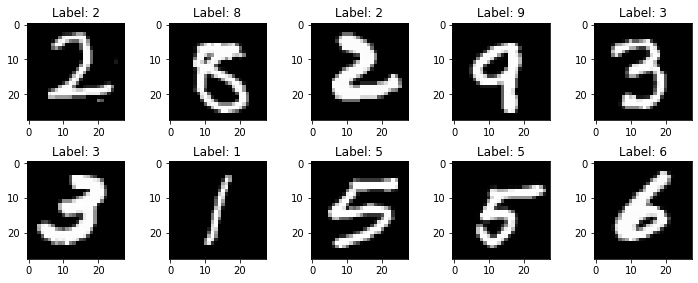

In [ ]:
# Show some examples from the MNIST dataset
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i in range(2):
    for j in range(5):
        idx = np.random.randint(len(train_dataset))
        img, label = train_dataset[idx]
        axs[i, j].imshow(img.squeeze(), cmap='gray')
        axs[i, j].set_title(f'Label: {label}')
plt.tight_layout()
plt.show()

In [ ]:
def create_triplets(dataset):
    """
    Create triplets of images from a given dataset.

    Args:
        dataset: A PyTorch dataset object.

    Returns:
        A list of triplets, where each triplet is a tuple (anchor, positive, negative),
        and each element in the tuple is a PyTorch tensor of shape (1, 28, 28).
    """
    triplets = []
    for i in range(len(dataset)):
        # Select anchor image
        anchor_img, anchor_label = dataset[i]
        anchor_img = torch.from_numpy(anchor_img.numpy())

        # Select positive image with the same label as the anchor image
        positive_indices = np.where(dataset.targets == anchor_label)[0]
        positive_idx = np.random.choice(positive_indices)
        positive_img, _ = dataset[positive_idx]
        positive_img = torch.from_numpy(positive_img.numpy())

        # Select negative image with a different label than the anchor image
        negative_indices = np.where(dataset.targets != anchor_label)[0]
        negative_idx = np.random.choice(negative_indices)
        negative_img, _ = dataset[negative_idx]
        negative_img = torch.from_numpy(negative_img.numpy())

        triplets.append((anchor_img, positive_img, negative_img))

    return triplets

In [ ]:
# Create Siamese triplets from the training dataset
train_triplets = create_triplets(train_dataset)
test_triplets = create_triplets(test_dataset)

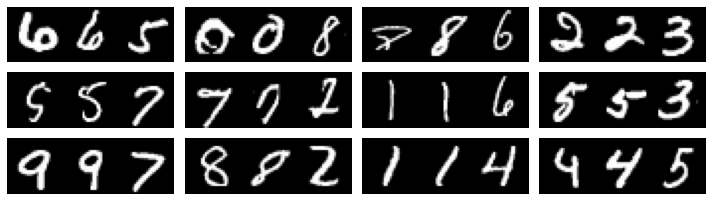

In [ ]:
# Display some random triplets
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(10,3))
for i in range(3):
    for j in range(4):
        anchor, positive, negative = train_triplets[np.random.randint(len(train_triplets))]
        axs[i, j].imshow(torch.cat((anchor, positive, negative), dim=2).squeeze(), cmap='gray')
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Define a function to create a DataLoader for the triplets
def create_dataloader(triplets, batch_size):
    """
    Create a DataLoader for a given set of triplets.
    """
    dataset = torch.utils.data.TensorDataset(*[torch.stack(t) for t in zip(*triplets)])
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [ ]:
# Create a DataLoader for the triplets
batch_size = 28
num_epochs = 2
train_dataloader = create_dataloader(train_triplets, batch_size)
test_dataloader = create_dataloader(test_triplets, batch_size)

In [ ]:
class SiameseNet(nn.Module):
    def __init__(self):
        super(SiameseNet, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(7 * 7 * 64, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x1, x2):
        # Forward pass for first input
        out1 = self.conv1(x1)
        out1 = torch.nn.functional.relu(out1)
        out1 = torch.nn.functional.max_pool2d(out1, 2)
        out1 = self.conv2(out1)
        out1 = torch.nn.functional.relu(out1)
        out1 = torch.nn.functional.max_pool2d(out1, 2)
        out1 = out1.view(out1.size(0), -1)
        out1 = self.fc1(out1)
        out1 = torch.nn.functional.relu(out1)
        out1 = self.fc2(out1)

        # Forward pass for second input
        out2 = self.conv1(x2)
        out2 = torch.nn.functional.relu(out2)
        out2 = torch.nn.functional.max_pool2d(out2, 2)
        out2 = self.conv2(out2)
        out2 = torch.nn.functional.relu(out2)
        out2 = torch.nn.functional.max_pool2d(out2, 2)
        out2 = out2.view(out2.size(0), -1)
        out2 = self.fc1(out2)
        out2 = torch.nn.functional.relu(out2)
        out2 = self.fc2(out2)

        return out1, out2

In [ ]:
def test_model(model, test_dataloader):
    """
    Evaluate the model on the test set and return the accuracy.
    """
    # Set the model to evaluation mode
    model.eval()

    # Keep track of the number of correct predictions
    num_correct = 0

    # Iterate over the test set
    for batch_idx, batch in enumerate(test_dataloader):
        # Extract the anchor, positive, and negative images from the batch
        anchor_imgs, positive_imgs, negative_imgs = batch

        # Forward pass
        anchor_out, positive_out = model(anchor_imgs, positive_imgs)
        anchor_out, negative_out = model(anchor_imgs, negative_imgs)

        # Calculate the distances between the anchor and positive/negative embeddings
        pos_dist = F.pairwise_distance(anchor_out, positive_out)
        neg_dist = F.pairwise_distance(anchor_out, negative_out)

        # Compute the binary classification labels (1 if positive pair, 0 if negative pair)
        labels = (pos_dist < neg_dist).float()

        # Compute the number of correct predictions
        num_correct += torch.sum(labels).item()

    # Compute the accuracy
    accuracy = num_correct / len(test_dataloader.dataset)

    # Print the accuracy
    print(f"Test Accuracy: {accuracy}")

    return accuracy

In [ ]:
# Instantiate the model and define the optimizer
model = SiameseNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the loss function
criterion = nn.TripletMarginLoss(margin=1.0)

# Set the model to train mode
model.train()

# Train the model
for epoch in range(num_epochs):
    for batch_idx, batch in enumerate(train_dataloader):
        # Zero the gradients
        optimizer.zero_grad()

        # Extract the anchor, positive, and negative images from the batch
        anchor_imgs, positive_imgs, negative_imgs = batch

        # Forward pass
        anchor_out, positive_out = model(anchor_imgs, positive_imgs)
        anchor_out, negative_out = model(anchor_imgs, negative_imgs)

        # Calculate the loss
        loss = criterion(anchor_out, positive_out, negative_out)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Print progress
        if batch_idx % 100 == 0:
            print(f"Epoch {epoch+1}, Batch_index {batch_idx}, Loss {loss.item()}")
    # Evaluate the model on the test set
    test_model(model, test_dataloader)

Epoch 1, Batch 0, Loss 0.9920836091041565
Epoch 1, Batch 100, Loss 0.45148709416389465
Epoch 1, Batch 200, Loss 0.37248721718788147
Epoch 1, Batch 300, Loss 0.14944685995578766
Epoch 1, Batch 400, Loss 0.037701722234487534
Epoch 1, Batch 500, Loss 0.010216125287115574
Epoch 1, Batch 600, Loss 0.0
Epoch 1, Batch 700, Loss 0.0894353985786438
Epoch 1, Batch 800, Loss 0.15870629251003265
Epoch 1, Batch 900, Loss 0.09799647331237793
Epoch 1, Batch 1000, Loss 0.004647272173315287
Epoch 1, Batch 1100, Loss 0.10513002425432205
Epoch 1, Batch 1200, Loss 0.02023215778172016
Epoch 1, Batch 1300, Loss 0.16305282711982727
Epoch 1, Batch 1400, Loss 0.02108575589954853
Epoch 1, Batch 1500, Loss 0.11514339596033096
Epoch 1, Batch 1600, Loss 0.05615511164069176
Epoch 1, Batch 1700, Loss 0.0
Epoch 1, Batch 1800, Loss 0.06906907260417938
Epoch 1, Batch 1900, Loss 0.04768417030572891
Epoch 1, Batch 2000, Loss 0.025661153718829155
Epoch 1, Batch 2100, Loss 0.026800572872161865
Test Accuracy: 0.9798
Epoch 2

In [ ]:
def plot_test_triplets(model, dataloader, num_triplets=5):
    # Select a random subset of triplets from the test set
    triplet = iter(dataloader)
    triplets = next(triplet)
    anchor_imgs, positive_imgs, negative_imgs = triplets

    # Make predictions on each triplet and plot the results
    for idx in range(num_triplets):
        # Select one triplet
        anchor_img, positive_img, negative_img = anchor_imgs[idx], positive_imgs[idx], negative_imgs[idx]

        # Make predictions on the anchor, positive, and negative images
        anchor_img_tens = torch.tensor(anchor_img.unsqueeze(0))
        positive_img_tens = torch.tensor(positive_img.unsqueeze(0))
        negative_img_tens = torch.tensor(negative_img.unsqueeze(0))
        anchor_pred, _ = model(anchor_img_tens, anchor_img_tens)
        positive_pred, _ = model(positive_img_tens, positive_img_tens)
        negative_pred, _ = model(negative_img_tens, negative_img_tens)

        # Select the embeddings from the tuples and convert them into tensors
        anchor_pred = anchor_pred.squeeze()
        positive_pred = positive_pred.squeeze()
        negative_pred = negative_pred.squeeze()

        # Compute the distances between the embeddings
        pos_dist = F.pairwise_distance(anchor_pred, positive_pred)
        neg_dist = F.pairwise_distance(anchor_pred, negative_pred)

        # Plot the triplet images and their distances
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
        ax1.imshow(anchor_img.permute(1, 2, 0))
        ax1.set_title('Anchor')
        ax2.imshow(positive_img.permute(1, 2, 0))
        ax2.set_title('Positive')
        ax3.imshow(negative_img.permute(1, 2, 0))
        ax3.set_title('Negative')
        fig.suptitle(f'Distance. pos: {pos_dist.item():.2f}, neg: {neg_dist.item():.2f}')
        plt.show()


<ipython-input-17-c14ad6e29552>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  anchor_img_tens = torch.tensor(anchor_img.unsqueeze(0))
<ipython-input-17-c14ad6e29552>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positive_img_tens = torch.tensor(positive_img.unsqueeze(0))
<ipython-input-17-c14ad6e29552>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  negative_img_tens = torch.tensor(negative_img.unsqueeze(0))


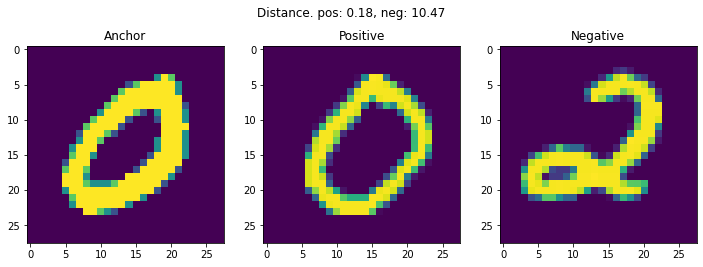

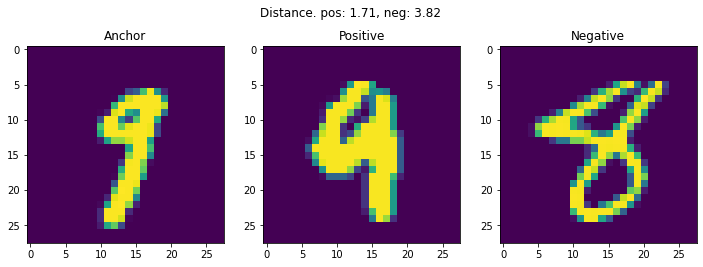

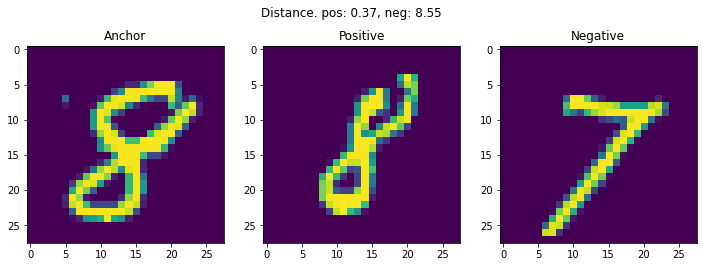

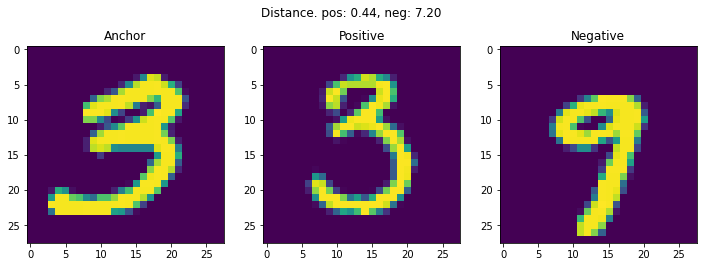

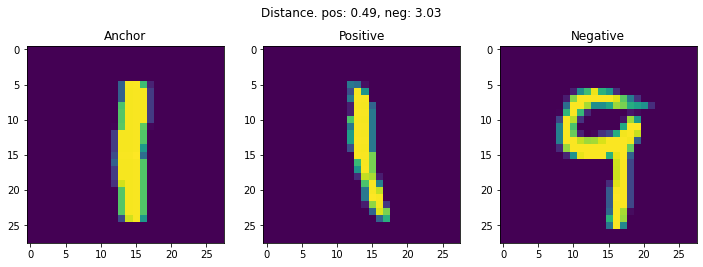

In [ ]:
# Plot test triplets with their distance values as labels
plot_test_triplets(model, test_dataloader);